# LIME Explanation for Hypertension Detection
In this notebook, we will walk through interpreting a machine learning problem (predicting the risk of developing hypertension) using records of the Cardiorespiratory Fitness dataset from the Henry Ford Testing (FIT) Project.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

## Reading the Dataset

In [2]:
df = pd.read_csv('HTN.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23095 entries, 0 to 23094
Data columns (total 50 columns):
studycode                         23095 non-null int64
age                               23095 non-null float64
sex                               23095 non-null object
bmi                               13543 non-null float64
mets_achieved                     23095 non-null float64
mets_c                            23095 non-null int64
resting_heart_rt                  23095 non-null int64
resting_systolic                  23095 non-null int64
resting_diastolic                 23095 non-null int64
peak_heart_rt                     23095 non-null int64
peak_systolic                     23057 non-null float64
peak_diastolic                    23023 non-null float64
percent_hr_achieved               23095 non-null float64
adequatestudy85                   23095 non-null int64
0rm_rest_ekg_flg                  20962 non-null float64
reason                            23095 non-null ob

## Data Preprocessing
### Handling Missing Values

In [3]:
null_idx = df[df['peak_diastolic'].isnull()].index.tolist()

In [4]:
df['peak_diastolic'][df['peak_diastolic'].isnull()] = df['peak_diastolic'].mean()

In [ ]:
df.iloc[null_idx[0]]

### Outliers

In [ ]:
df_q1 = df.quantile(q=0.25)
df_q3 = df.quantile(q=0.75)
df_iqr = df_q3 - df_q1

In [ ]:
numeric_cols = ['age', 'mets_achieved', 'resting_systolic', 'resting_diastolic',
       'peak_diastolic', 'hyperlipid', 'percent_hr_achieved']
for col_name in numeric_cols:
    col_mask = (df[col_name] >= (df_q1[col_name] - (1.5 * df_iqr[col_name]))) & (df[col_name] <= (df_q3[col_name] + (1.5 * df_iqr[col_name])))
    df[col_name] = df[col_name][col_mask]

## Select used features and target from the dataset

In [5]:
# Select used columns only (features and target)
df_all = df[["age","mets_achieved","resting_systolic","resting_diastolic","peak_diastolic","reason","htnresponse","k0wncad","dm","aspirin","hyperlipid","black","percent_hr_achieved","newHTN"]]

In [ ]:
df_all.dropna(inplace=True)

In [ ]:
df_all.info()

** Note: number of records after removing outliers = 21515 **

### Discretization

In [7]:
disc_cols = ["age","mets_achieved","resting_systolic","resting_diastolic","peak_diastolic","percent_hr_achieved"]
quantile_labels = [1, 2, 3, 4]
quantile_list = [0, .25, .5, .75, 1.]

In [8]:
for col_name in disc_cols:
    df_all[col_name] = pd.qcut(df_all[col_name], labels= quantile_labels, q=quantile_list)

In [ ]:
df_all.info()

### Generate a label encoding scheme for the 'reason' attribute

In [9]:
df_all.reason.unique()

array(['Chest Pain', 'Pre-Operation', 'Ab0rmal Test', 'Rule out Ischemia',
       'K0wn CAD', 'Shortness of Breath', 'Other', 'Arrhythmia',
       'Palpitation', 'Screening, Research', 'Dizzy, Fatigue',
       'Risk Factor', 'Conduction System Disease'], dtype=object)

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
reason_labels = le.fit_transform(df_all['reason'])
reason_mappings = {index: label for index, label in enumerate(le.classes_)}
reason_mappings

{0: 'Ab0rmal Test',
 1: 'Arrhythmia',
 2: 'Chest Pain',
 3: 'Conduction System Disease',
 4: 'Dizzy, Fatigue',
 5: 'K0wn CAD',
 6: 'Other',
 7: 'Palpitation',
 8: 'Pre-Operation',
 9: 'Risk Factor',
 10: 'Rule out Ischemia',
 11: 'Screening, Research',
 12: 'Shortness of Breath'}

In [11]:
df_all['reason'] = reason_labels

In [14]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23095 entries, 0 to 23094
Data columns (total 14 columns):
age                    23095 non-null category
mets_achieved          23095 non-null category
resting_systolic       23095 non-null category
resting_diastolic      23095 non-null category
peak_diastolic         23095 non-null category
reason                 23095 non-null int64
htnresponse            23095 non-null int64
k0wncad                23095 non-null int64
dm                     23095 non-null int64
aspirin                23095 non-null int64
hyperlipid             23095 non-null int64
black                  23095 non-null int64
percent_hr_achieved    23095 non-null category
newHTN                 23095 non-null int64
dtypes: category(6), int64(8)
memory usage: 1.5 MB


### Extract Used Features

In [12]:
df_feats = df_all[["age","mets_achieved","resting_systolic","resting_diastolic","peak_diastolic","reason","htnresponse","k0wncad","dm","aspirin","hyperlipid","black","percent_hr_achieved"]]
df_target = df_all[["newHTN"]]

In [ ]:
df_feats.info()

### Handling class imbalance with SMOTE

In [ ]:
df_target.newHTN.sum()

Number of positive class instances = 7302, and negative class instances = 14213

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

X, y = df_feats, df_target
print('Original dataset shape {}'.format(Counter(y['newHTN'])))
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_sample(X, y)
X_resampled = pd.DataFrame(X_res)
X_resampled.columns = X.columns
y_resampled = pd.DataFrame(y_res)
y_resampled.columns = y.columns

print('Resampled dataset shape {}'.format(Counter(y_res)))

In [ ]:
# recover labels for categorical attributes after resampling
X_resampled = X_resampled.round()

## Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

In [13]:
# without SMOTE
from sklearn.model_selection import train_test_split

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(df_feats, df_target, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(16166, 13)
(6929, 13)
(16166, 1)
(6929, 1)


## Baseline model

In [14]:
# Calculate mean absolute error
def mean_abs_error(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [15]:
baseline_guess = np.mean(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mean_abs_error(y_test, baseline_guess))

The baseline guess is a score of 0.34
Baseline Performance on the test set: MAE = 0.4575


The naive method of guessing the median training value provides us a low baseline for our models to beat! 

In [ ]:
# Save the cleaned data
X.to_csv('data/training_features.csv', index = False)
X_test.to_csv('data/testing_features.csv', index = False)
y.to_csv('data/training_labels.csv', index = False)
y_test.to_csv('data/testing_labels.csv', index = False)


In [16]:
# No SMOTE
X.to_csv('data/training_features_noSMOTE.csv', index = False)
X_test.to_csv('data/testing_features_noSMOTE.csv', index = False)
y.to_csv('data/training_labels_noSMOTE.csv', index = False)
y_test.to_csv('data/testing_labels_noSMOTE.csv', index = False)


# ML Models
The data will be trained using three models (ANN, Random Forest and SVM)

In [17]:
# Convert X, y to arrays (vector)
X = np.array(X)
X_test = np.array(X_test)
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [19]:
# Function to calculate mean absolute error
def mean_absolute_error(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mean_absolute_error(y_test, model_pred)
    acc = accuracy_score(y_test, model_pred)
    # Return the performance metric
    return model_mae, acc

In [ ]:
# Multi-layer perceptron classifier
ANN = MLPClassifier()
ANN_mae, accuracy = fit_and_evaluate(ANN)

print('Multilayer Perceptron Classifier Performance on the test set: MAE = %0.4f' % ANN_mae)
print('Accuracy: %0.4f' % accuracy)

In [21]:
# Random Forest classifier
rtf = RandomForestClassifier(n_estimators= 50)
rtf_mae, accuracy = fit_and_evaluate(rtf)

print('Random Forest Classifier Performance on the test set: MAE = %0.4f' % rtf_mae)
print('Accuracy: %0.4f' % accuracy)

Random Forest Classifier Performance on the test set: MAE = 0.3647
Accuracy: 0.6353


In [ ]:
# Support vector machine classifier
svm = SVC()
svm_mae, accuracy = fit_and_evaluate(svm)

print('Support Vector Machine Classifier Performance on the test set: MAE = %0.4f' % svm_mae)
print('Accuracy: %0.4f' % accuracy)

# Wrong Predictions Categories

Extract the wrongly classified instances (False positive and false negative instances)

In [23]:
preds_binary = rtf.predict(X_test)
preds_prob = rtf.predict_proba(X_test)

# find correct and wrong predictions
abs_diff = abs(preds_binary - y_test)
    
wrong_instances = X_test[abs_diff==1,:]
right_instances = X_test[abs_diff==0,:]

In [24]:
len(wrong_instances)

2527

In [25]:
rtf.classes_

array([0, 1], dtype=int64)

In [26]:
len(preds_binary)

6929

## Check the Cutoff Probability
Make sure that the cutoff probability is 0.5

In [27]:
preds_half = []
for p in preds_prob:
    if p[0] >= 0.5:
        preds_half.append(0)
    else:
        preds_half.append(1)
        
compare = (preds_half == preds_binary)*1
len(compare)

6929

In [28]:
# True positive: Sick people correctly identified as sick
# False positive: Healthy people incorrectly identified as sick
# True negative: Healthy people correctly identified as healthy
# False negative: Sick people incorrectly identified as healthy
    
def categories(y_actual, y_hat):
    TP = []
    FP = []
    TN = []
    FN = []

    for i in range(len(y_hat)): 
        if y_actual[i] == y_hat[i] == 1:
            TP.append(i)
        if y_hat[i] == 1  and y_actual[i] != y_hat[i]:
            FP.append(i)
        if y_actual[i] == y_hat[i] == 0:
            TN.append(i)
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN.append(i)


    return(TP, FP, TN, FN)

In [30]:
# Categorize the test set instances as the four (True positive, true negative, false positive, false negative)
tp_idx, fp_idx, tn_idx, fn_idx = categories(y_test, preds_binary)

In [31]:
# Check the number of wrong instances matched the output
len(wrong_instances) == len(fp_idx) + len(fn_idx)

True

## Sort the False instances by their probabilities

In [32]:
# Extract the probabilities of the right class of the FP and FN instances
fp_probs = []
fn_probs = []

for idx in fp_idx:
        fp_probs.append(preds_prob[idx][0])
        
for idx in fn_idx:
        fn_probs.append(preds_prob[idx][1])

In [33]:
zipped = zip(fp_probs, fp_idx)
fp_sorted  = sorted(zipped)

zipped = zip(fn_probs, fn_idx)
fn_sorted  = sorted(zipped)

## Save the Sorted Probabilities
Each of fp_sorted and fn_sorted has list of tuples (probability of their right class, instance's index in the dataset)

In [34]:
df_fn = pd.DataFrame(fn_sorted, columns=['right_prob', 'test_idx'])
df_fp = pd.DataFrame(fp_sorted, columns=['right_prob', 'test_idx'])

In [35]:
df_fn.to_csv('data/fn_noSMOTE.csv', index = False)
df_fp.to_csv('data/fp_noSMOTE.csv', index = False)

# Interpreting the RTF model with LIME

In [36]:
preds = rtf.predict(X_test)

# find correct and wrong predictions
abs_diff = abs(preds - y_test)
    
# Exact the worst and best prediction
wrong = X_test[np.argmax(abs_diff), :]
correct = X_test[np.argmin(abs_diff), :]

In [37]:
# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [38]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X, 
                                                   mode = 'classification',
                                                   training_labels = y,
                                                   feature_names = df_feats.columns.tolist())

C:\Users\Pealik\Anaconda3\envs\ml_inter\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Prediction: 0
Actual Value: 1


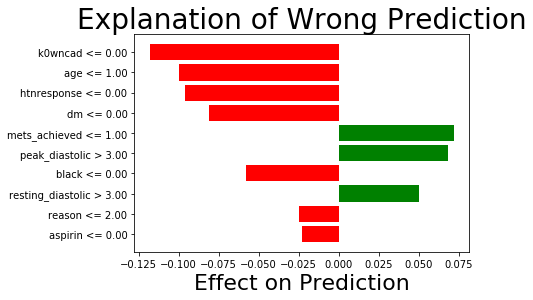

In [39]:
# Display the predicted and true value for the wrong example
print('Prediction: %d' % rtf.predict(wrong.reshape(1, -1)))
print('Actual Value: %d' % y_test[np.argmax(abs_diff)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = rtf.predict_proba)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Wrong Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [ ]:
wrong
wrong_df = pd.Series(wrong, index=df_feats.columns )
wrong_df

In [ ]:
# Display the predicted and true value for the wrong instance
print('Prediction: %d' % rtf.predict(correct.reshape(1, -1)))
print('Actual Value: %d' % y_test[np.argmin(abs_diff)])

# Explanation for wrong prediction
correct_exp = explainer.explain_instance(correct, rtf.predict_proba)
correct_exp.as_pyplot_figure();
plt.title('Explanation of Correct Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [ ]:
correct_df = pd.Series(correct, index=df_feats.columns )


In [ ]:
correct_df

# Interpreting the RTF Model with Anchors

In [ ]:
from anchor import anchor_tabular
from anchor import utils

In [ ]:
# frames = [X_resampled, y_resampled]
# df_all_final = pd.concat(frames, axis=1)

# without SMOTE
frames = [df_feats, df_target]
df_all_final = pd.concat(frames, axis=1)

In [ ]:
df_all_final.to_csv('data/dataset_all.csv', index = False)
dataset_csv = 'data/dataset_all.csv'

In [ ]:
feature_names = df_all_final.columns.tolist()
features_to_use = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
categorical_feats = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
feature_names

In [ ]:
dataset = utils.load_csv_dataset(dataset_csv, target_idx= 13, delimiter=',',
                             feature_names=feature_names, categorical_features=categorical_feats,
                            feature_transformations=None, discretize=False, balance=False, fill_na='-1', skip_first=True,
                                features_to_use=features_to_use)

In [ ]:
explainerAnchor = anchor_tabular.AnchorTabularExplainer(dataset.class_names, dataset.feature_names, dataset.data, dataset.categorical_names)
explainerAnchor.fit(dataset.train, dataset.labels_train, dataset.validation, dataset.labels_validation)

In [ ]:
rtf.fit(explainerAnchor.encoder.transform(dataset.train), dataset.labels_train)
predict_fn = lambda x: rtf.predict(explainerAnchor.encoder.transform(x))

In [ ]:
print('Train', accuracy_score(dataset.labels_train, predict_fn(dataset.train)))
print('Test', accuracy_score(dataset.labels_test, predict_fn(dataset.test)))

## Getting an Anchor
Below, we get an anchor for prediction number 0. An anchor is a sufficient condition - that is, when the anchor holds, the prediction should be the same as the prediction for this instance.

In [ ]:
idx = 0
np.random.seed(1)
desired_label = predict_fn(dataset.test[idx].reshape(1, -1))[0]
print('Prediction: ', explainerAnchor.class_names[predict_fn(dataset.test[idx].reshape(1, -1))[0]])

In [ ]:
exp = explainerAnchor.explain_instance(dataset.test[idx], rtf.predict, threshold=0.95)

In [ ]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Note that we set threshold to 0.95, so we guarantee (with high probability) that precision will be above 0.95 - that is, that predictions on instances where the anchor holds will be the same as the original prediction at least 95% of the time. Let's try it out on the test set

In [ ]:
# Get test examples where the anchora pplies
fit_anchor = np.where(np.all(dataset.test[:, exp.features()] == dataset.test[idx][exp.features()], axis=1))[0]
print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(dataset.test.shape[0])))
print('Anchor test precision: %.2f' % (np.mean(predict_fn(dataset.test[fit_anchor]) == predict_fn(dataset.test[idx].reshape(1, -1)))))

## Looking at a Particular Anchor

You can look at just part of the anchor - for example, the first two clauses. Note how these do not have enough precision, which is why the explainer added a third one

In [ ]:
print('Partial anchor: %s' % (' AND '.join(exp.names(1))))
print('Partial precision: %.2f' % exp.precision(1))
print('Partial coverage: %.2f' % exp.coverage(1))

In [ ]:
fit_partial = np.where(np.all(dataset.test[:, exp.features(1)] == dataset.test[idx][exp.features(1)], axis=1))[0]
print('Partial anchor test precision: %.2f' % (np.mean(predict_fn(dataset.test[fit_partial]) == predict_fn(dataset.test[idx].reshape(1, -1)))))
print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(dataset.test.shape[0])))

## See a visualization of the anchor with examples and etc 

In [ ]:
exp.show_in_notebook()